# 6. Decision Trees and Ensemble Learning


Ансамблиевые алгоритмы, деревья решений

## 6.1 Credit risk scoring project

* Dataset: https://github.com/gastonstat/CreditScoring

Задача  кредитного скоринга (оценки рисков)
- status: Статус текущего кредита или долгового обязательства.
- seniority: Стаж работы заемщика (в годах).
- home: Тип собственности на жилье (например, собственное жилье, арендованное и т.д.).
-  time: Срок текущего проживания на одном месте (в месяцах).
- age: Возраст заемщика.
- marital: Семейное положение заемщика (например, одинокий, женат и т.д.).
- records: Наличие кредитной истории или проблем с кредитами.
- job: Тип занятости (например, постоянная работа, временная работа и т.д.).
- expenses: Ежемесячные расходы заемщика.
- income: Месячный доход заемщика.
- assets: Наличие активов или сбережений.
- debt: Сумма долговых обязательств заемщика.
- amount: Запрашиваемая сумма кредита.
- price: Оценочная стоимость имущества, предоставляемого в залог.


Задача бинарной классификации


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

* Скачиваем набор данных
* Расшифровываем категориальные переменные
* Делим данные на обучающий/тестовый/валидационный

In [3]:
data_path = 'CreditScoring.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
df

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [12]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [14]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [18]:
del df_train['status']
del df_val['status']
del df_test['status']

In [19]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision trees

Представьте себе древовидную структуру, где каждый внутренний узел представляет признак или атрибут, каждая ветвь обозначает решение или результат, а каждый конечный узел обеспечивает окончательное предсказание или классификацию.

Деревья решений широко используются для таких задач, как классификация и регрессия. Они известны своей простотой и легкостью интерпретации, что делает их ценным ресурсом для понимания и решения сложных проблем.

* How a decision tree looks like
* Training a decision tree 
* Overfitting
* Controlling the size of a tree

Дерево решений — это структура данных, где у нас есть узел, который является условием. И из этого узла есть одна стрелка влево (условие = ложь) и одна вправо (условие = истина). Затем есть следующее условие, которое может быть истинным или ложным. … пока не будет принято окончательное решение «ОК» или «ПО УМОЛЧАНИЮ»


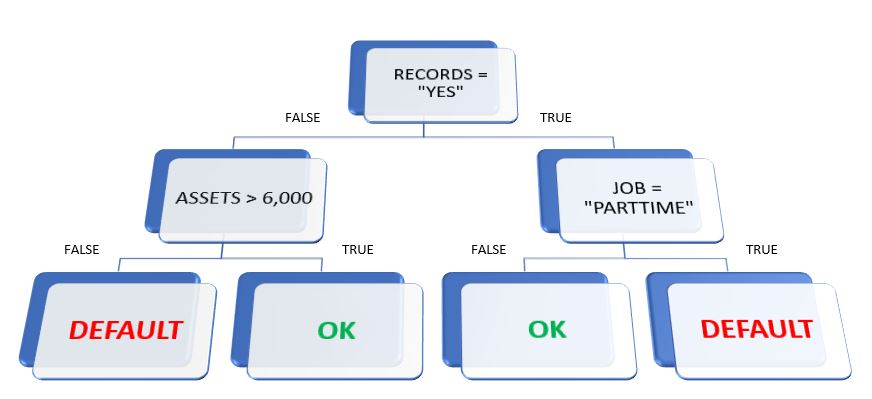

In [20]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [21]:
xi = df_train.iloc[0].to_dict()

In [22]:
assess_risk(xi)

'ok'

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [24]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6570499624615533

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Переобучение — это когда наша модель просто запоминает данные, но запоминает таким образом, что когда она видит новый пример, она не знает, что с этим примером делать. Поэтому она запоминает обучающие данные, но не может их обобщить. Причина, по которой это происходит с деревьями решений, заключается в том, что модель создает определенное правило для каждого примера. Это отлично работает для обучающих данных, но не работает для любого невидимого примера. Причина, по которой это может произойти, заключается в том, что мы позволяем дереву расти слишком глубоко. 


Дерево решений с глубиной 1 называется Decision Stump . Это не совсем дерево, потому что это только одно условие.

In [30]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [31]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [32]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## 6.4 Decision tree learning algorithm

* Найдем лучшее разделение для 1 столбца
* Лучшее разделение для всего набора данных
* Критерий остановки

In [33]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [34]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [35]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [36]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


default    0.75
ok         0.25
Name: status, dtype: float64


In [37]:
from IPython.display import display

In [38]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [39]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [40]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [41]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [42]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

#####################


Наиболее распространенными критериями остановки являются:

- Группа уже чистая :
если узел чистый, то есть все образцы в этом узле принадлежат к одному классу, дальнейшее разделение не нужно, поскольку оно не даст никакой дополнительной информации.
- Дерево достигло предела глубины (контролируется max_depth) :
ограничение глубины дерева помогает контролировать переобучение и гарантирует, что дерево не станет слишком сложным.
- Группа слишком мала для дальнейшего разделения (контролируется min_samples_leaf) :
ограничение разделения, когда количество образцов в узле падает ниже определенного порогового значения, помогает предотвратить переобучение и приводит к получению меньших, более интерпретируемых деревьев.

Используя эти критерии, мы обеспечиваем простоту в нашей модели, тем самым предотвращая переобучение. 

## 6.5 Decision trees parameter tuning

Некоторые из ключевых параметров включают:

- criterion (критерий оптимизации): этот параметр определяет меру примеси, используемую для разделения. Вы можете выбрать между 'gini' для примеси Джини и 'entropy' для прироста информации. Выбор критерия может существенно повлиять на качество разделений в дереве решений.

- max_depth: Этот параметр управляет максимальной глубиной дерева решений. Он играет решающую роль в предотвращении переобучения, ограничивая сложность дерева. Выбор подходящего значения для max_depth помогает найти баланс между простотой и сложностью модели.

- min_samples_leaf: Этот параметр определяет минимальное количество образцов, требуемых в листовом узле. Меньшие значения могут привести к более мелким расщеплениям и более сложному дереву, тогда как большие значения приводят к более грубым расщеплениям и более простому дереву.

In [43]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761


   5 -> 0.767
   6 -> 0.761
  10 -> 0.697
  15 -> 0.665
  20 -> 0.664
None -> 0.664


In [44]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [45]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [46]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.753
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

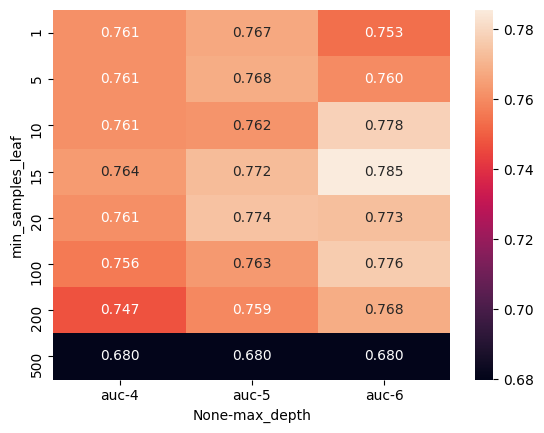

In [47]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [48]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [49]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- amount <= 525.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  525.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## 6.6 Ensembles and random forest


In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

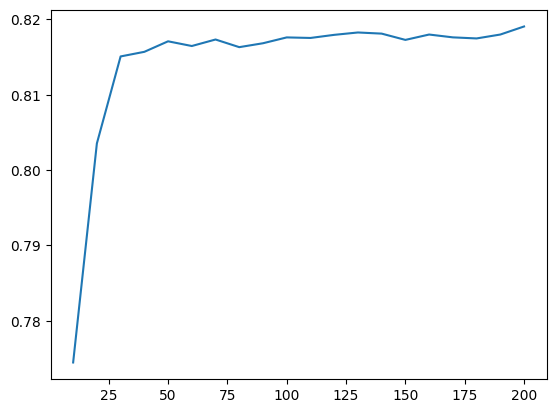

In [53]:
plt.plot(df_scores.n_estimators, df_scores.auc)

Мы наблюдаем, что производительность модели улучшается по мере увеличения количества оценщиков до 50, но после этого она достигает плато. Дополнительные деревья не дают значительного улучшения производительности. Следовательно, обучение более 50 деревьев, по-видимому, не приносит пользы.

In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [55]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

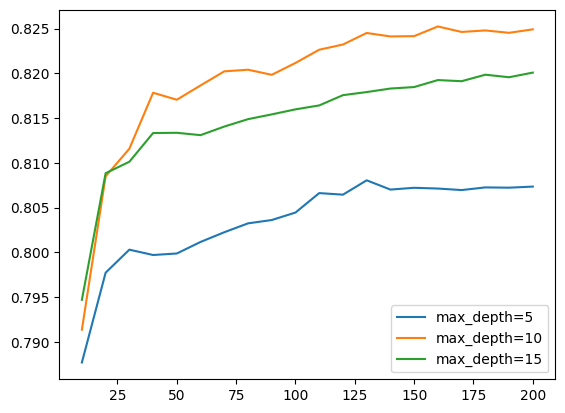

In [56]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [57]:
max_depth = 10

In [58]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [59]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

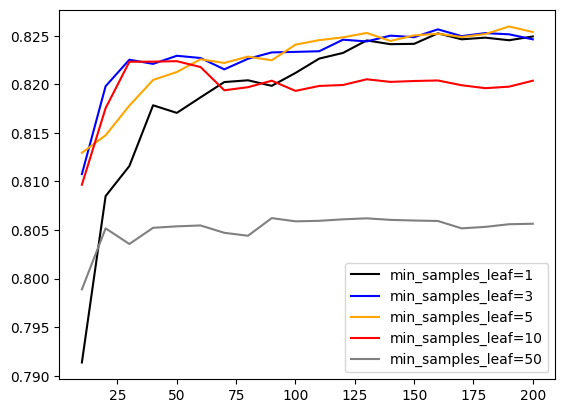

In [60]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [61]:
min_samples_leaf = 3

In [62]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Это не единственные два параметра, которые мы можем настроить в модели случайного леса. Есть еще несколько полезных параметров, которые следует учитывать:

- max_features: Этот параметр определяет, сколько признаков получает каждое дерево решений во время обучения. Важно помнить, что случайные леса работают, выбирая только подмножество признаков для каждого дерева.
- bootstrap: Bootstrap представляет другую форму рандомизации, но на уровне строк. Эта рандомизация гарантирует, что деревья решений будут максимально разнообразными.
- n_jobs: Обучение деревьев решений может быть распараллелено, поскольку все модели независимы друг от друга. Параметр 'n_jobs' указывает, сколько деревьев может быть обучено параллельно. Значение по умолчанию 'None', что означает отсутствие распараллеливания. Использование '-1' означает использование всех доступных процессоров, что может значительно ускорить процесс обучения.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 6.7 Gradient boosting and XGBoost

Основная идея бустинга — последовательное обучение нескольких моделей, где каждая последующая модель исправляет ошибки предыдущей.


При бустинге мы начинаем с набора данных и обучаем первую модель. Первая модель делает прогнозы, и мы оцениваем допущенные ошибки. Основываясь на этих ошибках, мы обучаем вторую модель, которая генерирует свои собственные прогнозы и в процессе вносит свои собственные ошибки. Затем мы обучаем третью модель, которая стремится исправить ошибки, допущенные второй моделью. Этот процесс можно повторять для нескольких итераций. В конце этих итераций мы объединяем прогнозы из этих нескольких моделей в окончательный прогноз.

In [63]:
!pip3 install xgboost

In [64]:
import xgboost as xgb

Первым шагом в этом процессе является структурирование обучающих данных в специализированный формат данных, известный как «DMatrix». Этот формат оптимизирован для обучения моделей XGBoost, что позволяет ускорить обучение.

Параметры XGBoost . Некоторые из наиболее важных параметров включают в себя:

- eta: этот параметр представляет собой скорость обучения, определяющую, насколько быстро обучается модель.
- max_depth: Подобно случайным лесам и деревьям решений, «max_depth» управляет размером деревьев.
- min_child_weight: этот параметр контролирует минимальное количество наблюдений, которые должны присутствовать в конечном узле, аналогично параметру «min_samples_leaf» в деревьях решений.
- objective: Поскольку у нас есть задача бинарной классификации, где мы стремимся классифицировать клиентов на «дефолтных» и «недефолтных», нам нужно указать «цель». Существуют различные цели, доступные для разных типов задач, включая регрессию и классификацию.
- nthread: XGBoost имеет возможность распараллеливать обучение, и здесь мы указываем, сколько потоков использовать.
- seed: этот параметр управляет рандомизацией, используемой в модели.
Подробность: позволяет нам контролировать уровень детализации предупреждений и сообщений, генерируемых во время обучения.

In [65]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [66]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [67]:
y_pred = model.predict(dval)

In [68]:
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [70]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [71]:
s = output.stdout

In [72]:
print(s[:200])

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	tr


In [73]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [74]:
df_score = parse_xgb_output(output)

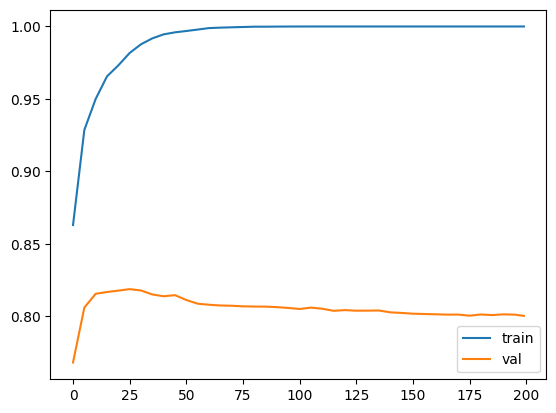

In [75]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

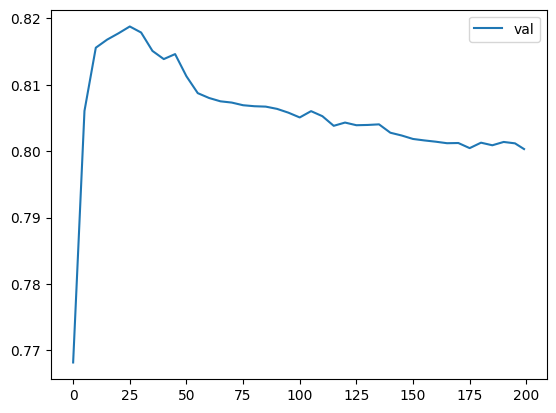

In [76]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning

* `eta`
* `max_depth`
* `min_child_weight`


In [77]:
scores = {}

In [78]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [79]:
scores = {}

In [80]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [81]:
scores = {}

In [82]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [83]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [84]:
del scores['max_depth=10']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


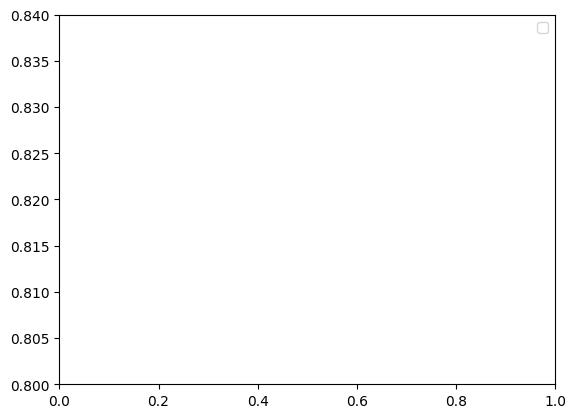

In [85]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

In [86]:
scores = {}

In [87]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [88]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

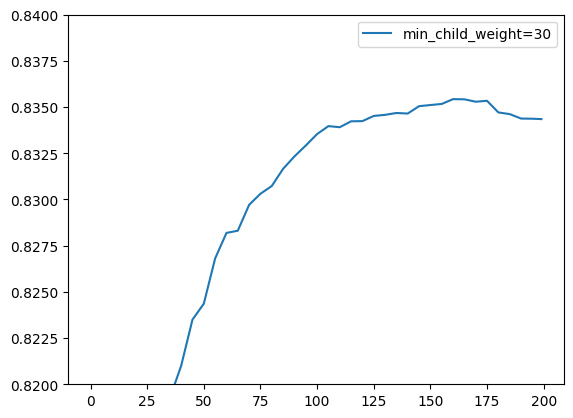

In [89]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [90]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html


* `subsample` and `colsample_bytree`
* `lambda` and `alpha`

## 6.9 Selecting the final model

*  xgboost, random forest, decision tree
* Обучение итоговой модели
* Сохранение модели

In [105]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [106]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7853194400716863

In [107]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [108]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [109]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [110]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

In [111]:
df_full_train = df_full_train.reset_index(drop=True)

In [112]:
y_full_train = (df_full_train.status == 'default').astype(int).values

AttributeError: 'DataFrame' object has no attribute 'status'

In [ ]:
del df_full_train['status']

In [ ]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [101]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [102]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [103]:
y_pred = model.predict(dtest)

In [104]:
roc_auc_score(y_test, y_pred)

0.8322662626460096

 ### 6.10 Итог

- Деревья решений учатся из данных правилам в форме «если – тогда».
- Нахождение лучшего разбиения: выбор наименее нечистого разбиения. Этот алгоритм может переобучиваться, поэтому мы контролируем это, ограничивая глубину и размер группы.
- Случайный лес является методом объединения нескольких деревьев решений. Лес должен состоять из разнообразных моделей, чтобы давать хорошие предсказания.
- Градиентный бустинг тренирует модели последовательно: каждая модель пытается исправить ошибки предыдущей. **XGBoost** является реализацией градиентного бустинга.

### 6.11 

- Для данного набора данных мы не делали предварительного анализа данных или обработки признаков. Хотя это может улучшить качество модели
- Для случайного леса есть дополнительные параметры, которые можно тонко настроить. Проверьте **max_features** и **bootstrap**.
- Есть вариация случайного леса, называемая  **Extra Trees**. Вместо того, чтобы выбирать лучшее разбиение среди всех возможных порогов, **Extra Trees** выбирают несколько порогов случайно и используют лучший из них. Поэтому эти деревья не переобучиваются. В **Scikit-Learn** они реализованы как **ExtraTreesClassifier**. Попробуйте их в этом проекте.
- **XGBoost** может работать с **NA** (незаполненные значения) — не нужно делать **fillna** для этого. Проверьте, может ли отсутствие **NA** улучшить результат.
- Экспериментируйте с другими параметрами **XGBoost**: **subsample** и **colsample_bytree**.
- При выборе лучшего разбиения деревья решений находят самые важные признаки. Эту информацию можно использовать для понимания, какие признаки вносят наибольший вклад в модель. Пример признаков для **random forest** и **xgboost** для понимания вклада признаков можно посмотреть здесь: [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
- Деревья также могут использоваться для решения задач регрессии: попробуйте **DecisionTreeRegressor**, **RandomForestRegressor** и параметр **objective=reg:squarederror** для **XGBoost**.

